# Impact of Transaction Costs on the Salopek Strategy

In [35]:
import numpy.typing as npt
import numpy as np
from typing import Union
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# own module
from simulations.fractional_brownian import (
    generate_brownian_path,
    generate_n_assets_portfolio,
)
from backtest.backtester import Backtester
from strategy.strategy import SalopekStrategy

from utility.utils import generate_t, a_order_power_mean, transaction_cost_L

In [36]:
N_SIMULATION = 10

ALPHA = -30
BETA = 30

# fees (no fees now)
P1 = 0  # 0.1 proportionality factor p1 (in percent)
P2 = 0  # 0.5 minimum fee p2 (in monetary units)

SCALING_FACTOR = 100  # \gamma


salopek_strat = SalopekStrategy(alpha=ALPHA, beta=BETA)
bk_tester = Backtester()

all_V_t_psi = []
all_V_t_phi = []
all_transaction_account = []

for _ in tqdm(
    range(N_SIMULATION),
    leave=False,
    desc="Computing MC simulation...",
    total=N_SIMULATION,
):
    df_ptf = generate_n_assets_portfolio(
        n_assets=2,
        n_steps=250,
        T=1,
        H=0.7,
        mu=0.05,
        sigma=0.1,
        s0=100,
        add_risk_free_asset=False,
        as_dataframe=True,
        brownian_type="fractional",
    )
    df, V_t_psi, V_t_phi, transaction_account = bk_tester.run_backtest(
        universe_dataframe=df_ptf,
        allocation_function=salopek_strat.get_allocation,
        p1=P1,
        p2=P2,
    )
    all_V_t_psi.append(V_t_psi)
    all_V_t_phi.append(V_t_phi)
    all_transaction_account.append(transaction_account)
    del df_ptf

generate all paths of the portfolio:   0%|          | 0/2 [00:00<?, ?it/s]

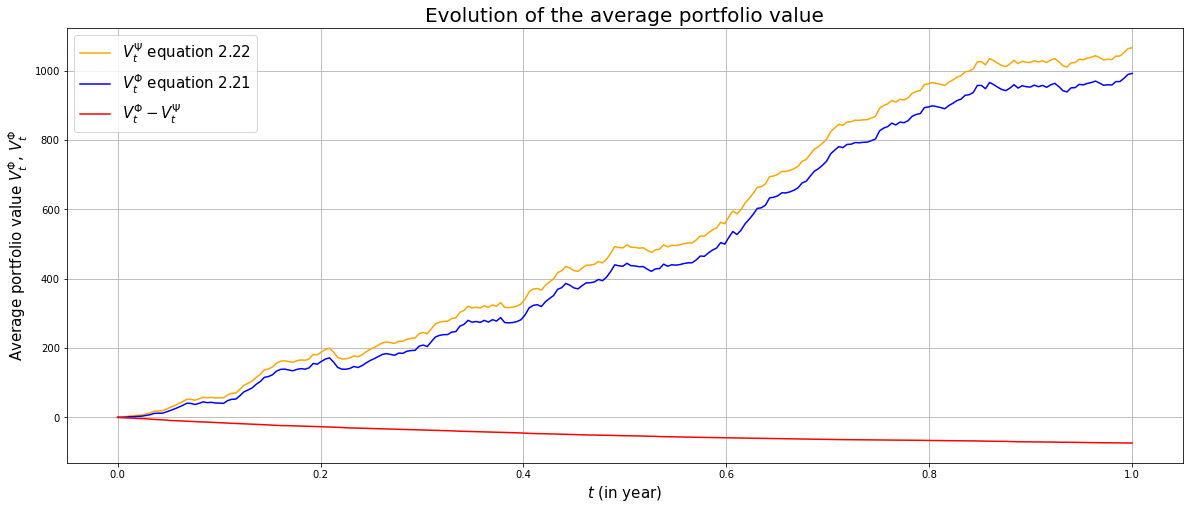

In [37]:
_, ax = plt.subplots(1, 1, figsize=(20, 8))
t = generate_t(250, 1)
ax.plot(
    t, np.mean(all_V_t_psi, axis=0), label=r"$V_t^\Psi$ equation 2.22", color="orange"
)
ax.plot(
    t,
    np.mean(all_V_t_phi, axis=0),
    # linestyle="--",
    label=r"$V_t^\Phi$ equation 2.21",
    color="blue",
)
ax.plot(
    t,
    np.mean(all_V_t_phi, axis=0) - np.mean(all_V_t_psi, axis=0),
    label=r"$V_t^\Phi-V_t^\Psi$",
    color="red",
)

ax.set_xlabel("$t$ (in year)", fontsize=15)
ax.set_ylabel(r"Average portfolio value $V_t^\Phi$, $V_t^\Phi$", fontsize=15)
ax.set_title(f"Evolution of the average portfolio value", fontsize=20)
ax.grid()
# ax_l2.legend(fontsize=15, loc="upper left")
ax.legend(fontsize=15, loc="upper left")

In [64]:
P = [[0, 0], [0.1, 0], [0.1, 0.5]]
N_SIMULATION = 100
ALPHA = -30
BETA = 30
SCALING_FACTOR = 100

salopek_strat = SalopekStrategy(alpha=ALPHA, beta=BETA)
bk_tester = Backtester()

terminal_portfolio_value_phi = []
terminal_portfolio_value_psi = []
running_minimum_phi = []
terminal_psi_minus_phi = []

for probas in P:
    terminal_V_t_psi = []
    terminal_V_t_phi = []
    min_V_t_phi = []
    term_diff = []
    for _ in tqdm(range(N_SIMULATION), leave=False, desc="Computing MC simulation...", total=N_SIMULATION):
        df_ptf = generate_n_assets_portfolio(
            n_assets=2,
            n_steps=251,
            T=1,
            H=0.7,
            mu=0.05,
            sigma=0.1,
            s0=100,
            add_risk_free_asset=False,
            as_dataframe=True,
            brownian_type="fractional",
        )
        _, V_t_psi, V_t_phi, transaction_account = bk_tester.run_backtest(
            universe_dataframe=df_ptf,
            allocation_function=salopek_strat.get_allocation,
            p1=probas[0],
            p2=probas[1],
        )
        terminal_V_t_psi.append(V_t_psi[-2])
        terminal_V_t_phi.append(V_t_phi[-2])
        min_V_t_phi.append(min(V_t_phi))
        term_diff.append(terminal_V_t_psi[-1] - terminal_V_t_phi[-1])
        del df_ptf
    terminal_portfolio_value_phi.append(terminal_V_t_phi)
    terminal_portfolio_value_psi.append(terminal_V_t_psi)
    running_minimum_phi.append(min_V_t_phi)
    terminal_psi_minus_phi.append(term_diff)

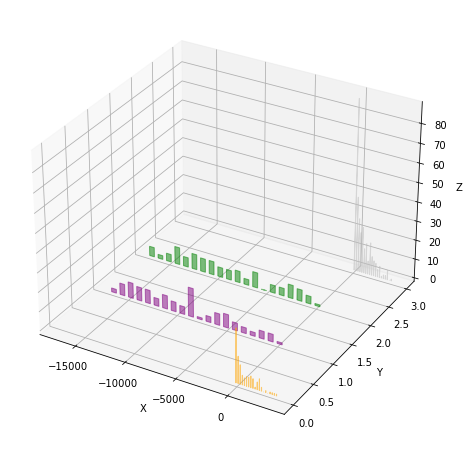

In [68]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
nbins = 20
colors = ['orange', 'purple', 'green', (0.75, 0.75, 0.75)]
y = [0, 1, 2, 3]
bar_width = [20, 500, 500, 20]
for i in range(4):
    if i != 3:
        ys = terminal_portfolio_value_phi[i]
    else:
        ys = terminal_portfolio_value_psi

    hist, bins = np.histogram(ys, bins=nbins)
    xs = (bins[:-1] + bins[1:])/2

    ax.bar(xs, hist, zs=y[i], zdir='y', color=colors[i], ec=colors[i], alpha=0.5, width=bar_width[i])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

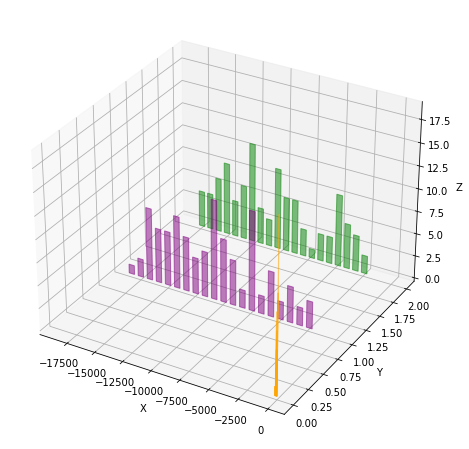

In [71]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
nbins = 20
colors = ['orange', 'purple', 'green']
y = [0, 1, 2]
bar_width = [20, 500, 500]
for i in range(3):
    ys = running_minimum_phi[i]

    hist, bins = np.histogram(ys, bins=nbins)
    xs = (bins[:-1] + bins[1:])/2

    ax.bar(xs, hist, zs=y[i], zdir='y', color=colors[i], ec=colors[i], alpha=0.5, width=bar_width[i])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

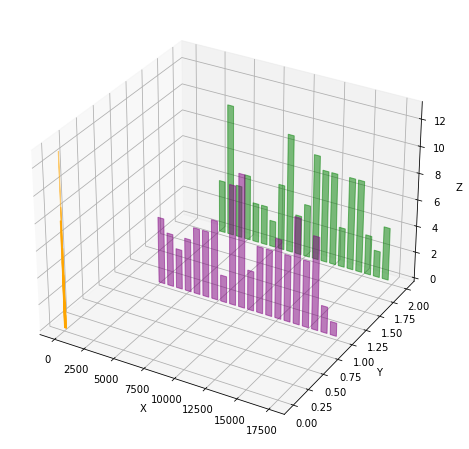

In [72]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
nbins = 20
colors = ['orange', 'purple', 'green']
y = [0, 1, 2]
bar_width = [20, 500, 500]
for i in range(3):
    ys = terminal_psi_minus_phi[i]

    hist, bins = np.histogram(ys, bins=nbins)
    xs = (bins[:-1] + bins[1:])/2

    ax.bar(xs, hist, zs=y[i], zdir='y', color=colors[i], ec=colors[i], alpha=0.5, width=bar_width[i])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()